<a href="https://colab.research.google.com/github/Anirbit-AI/1D-Burgers-By-DeepONet/blob/main/Inverting_Burger_Shock_Solutions_By_ConvNet_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader


# Shock Wave Solutions of Burgers PDE

For this task, we will implement a common form of the shock wave solution for the Burgers PDE. The specific formula we will use is:

$u(x, t) = \frac{x}{t} \cdot \frac{1}{1 + \sqrt{t/t_0} \exp(x^2 / 4\nu t)}$

where:
* $u(x,t)$ is the velocity at spatial coordinate $x$ and time $t$.
* $\nu$ is the kinematic viscosity.
* $t_0$ is a reference time
This formula provides a well-defined analytical solution that can be directly computed.

In [ ]:
def shock_wave_solution(x, t, nu, t0):
    """
    Computes the shock wave solution of the Burgers PDE using the specified formula.

    Args:
        x (float or np.ndarray): Spatial coordinate.
        t (float or np.ndarray): Time. Must be greater than zero.
        nu (float): Kinematic viscosity. Must be greater than zero.
        t0 (float): Reference time. Must be greater than zero.

    Returns:
        float or np.ndarray: Velocity u(x,t).
    """
    # In a physical context, t > 0, nu > 0, and t0 > 0 for this solution form to be meaningful.
    if np.any(t <= 0):
        raise ValueError("Time 't' must be greater than zero for this solution.")
    if np.any(nu <= 0):
        raise ValueError("Viscosity 'nu' must be greater than zero.")
    if t0 <= 0:
        raise ValueError("Reference time 't0' must be greater than zero.")

    # Compute the shock solution
    sqrt_term = np.sqrt(t / t0)
    exp_term = np.exp(x**2 / (4 * nu * t))
    denominator = 1 + sqrt_term * exp_term
    u = (x / t) * (1 / denominator)
    return u


## Choose $t_0$ and Generate Viscosity Values




In [ ]:
t_0 = 1
num_viscosity_values = 2**10
min_nu = 2**3
max_nu = 2**4
#[2^8,2^12] is very hard to invert

viscosity_values = np.random.uniform(min_nu, max_nu, num_viscosity_values)

print(f"Generated {num_viscosity_values} random viscosity values:")
print(viscosity_values)

Generated 1024 random viscosity values:
[14.9178462  15.90969342 14.4066136  ...  9.57784461  8.43308228
 11.58465362]


# Create Space-Time Grid


Define a uniform spatial grid (x) of size Nx and a uniform temporal grid (t) of size Nt.


In [ ]:

#Define the spatial domain
x_min = -5.0
x_max = 5.0

#Define the temporal domain
t_min = 0.01  # Must be greater than 0
t_max = 5.01

#Define the number of points for the spatial and temporal grids
Nx = 2**7
Nt = 2**7

#Create the 1D spatial array
x_values = np.linspace(x_min, x_max, Nx)

#Create the 1D temporal array
t_values = np.linspace(t_min, t_max, Nt)

#Use np.meshgrid to create 2D arrays X and T
X, T = np.meshgrid(x_values, t_values)

print(f"Spatial grid defined from {x_min} to {x_max} with {Nx} points.")
print(f"Temporal grid defined from {t_min} to {t_max} with {Nt} points.")
print(f"Shape of X (spatial mesh): {X.shape}")
print(f"Shape of T (temporal mesh): {T.shape}")

Spatial grid defined from -5.0 to 5.0 with 128 points.
Temporal grid defined from 0.01 to 5.01 with 128 points.
Shape of X (spatial mesh): (128, 128)
Shape of T (temporal mesh): (128, 128)


# Compute Shock Wave Solution for each Viscosity for fixed $t_0$

In [ ]:

# Temporarily suppress overflow warnings for np.exp
old_settings = np.seterr(over='ignore')

shock_wave_solutions = []

for i, nu_val in enumerate(viscosity_values):
    #print(f"Computing shock wave solution for viscosity nu = {nu_val:.4f}...")
    # Ensure X and T are passed as 2D arrays to the shock_wave_solution function
    u_solution = shock_wave_solution(X, T, nu_val,t_0)
    shock_wave_solutions.append(u_solution)

print(f"Computed {len(shock_wave_solutions)} shock wave solutions, each of shape {shock_wave_solutions[0].shape}.")

# Restore numpy error settings to their previous state
np.seterr(**old_settings)

Computed 1024 shock wave solutions, each of shape (128, 128).


{'divide': 'warn', 'over': 'ignore', 'under': 'ignore', 'invalid': 'warn'}

## Plot Sample Heatmaps of Shock Wave Solutions (in Viscosity Sorted Order)



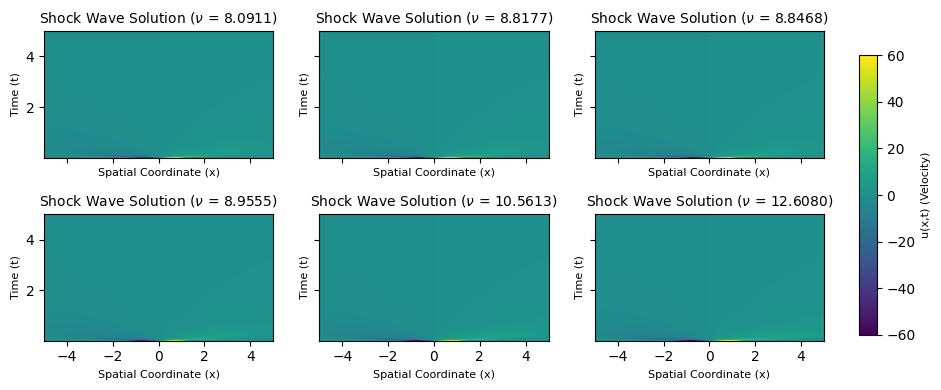

In [ ]:

# Number of random solutions to plot
num_solutions_to_plot = 6

# Generate random indices to select a subset of solutions
random_indices = random.sample(range(len(viscosity_values)), num_solutions_to_plot)

# Select the subset of viscosity values and solutions
selected_viscosity_values = [viscosity_values[i] for i in random_indices]
selected_shock_wave_solutions = [shock_wave_solutions[i] for i in random_indices]

# Combine the selected values with their solutions and sort them
sorted_solutions = sorted(zip(selected_viscosity_values, selected_shock_wave_solutions), key=lambda item: item[0])

# Determine the number of rows and columns for the subplot grid
num_solutions = len(sorted_solutions)
num_cols = 3  # You can adjust this based on desired layout
num_rows = (num_solutions + num_cols - 1) // num_cols # Ceiling division

# Calculate global min and max for consistent color scaling
all_solutions_flat = np.concatenate([sol.flatten() for _, sol in sorted_solutions])
global_vmin = all_solutions_flat.min()
global_vmax = all_solutions_flat.max()

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 2), sharex=True, sharey=True)
axes = axes.flatten() # Flatten the array of axes for easy iteration

# Keep track of the first image object to create a single colorbar
first_img = None

for i, (nu_val, u_solution) in enumerate(sorted_solutions):
    ax = axes[i]

    # Plot the heatmap using global vmin and vmax
    img = ax.imshow(u_solution, extent=[x_min, x_max, t_min, t_max],
                     origin='lower', aspect='auto', cmap='viridis', vmin=global_vmin, vmax=global_vmax)

    if first_img is None:
        first_img = img # Store the first image for the colorbar

    ax.set_title(r'Shock Wave Solution ($ν$ = ' + f'{nu_val:.4f})', fontsize=10) # Reduced font size
    ax.set_xlabel('Spatial Coordinate (x)', fontsize=8) # Reduced font size
    ax.set_ylabel('Time (t)', fontsize=8) # Reduced font size

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 0.95, 1]) # Adjust layout for colorbar

# Add a single colorbar for all subplots
cbar_ax = fig.add_axes([0.96, 0.15, 0.02, 0.7]) # [left, bottom, width, height]
cbar = fig.colorbar(first_img, cax=cbar_ax, label='u(x,t) (Velocity)')
cbar.set_label('u(x,t) (Velocity)', fontsize=8) # Set fontsize for colorbar label

plt.show()


# Prepare Data for Neural Network




In [ ]:

#Convert shock_wave_solutions to a single PyTorch tensor
#shock_wave_solutions is a list of (Nt, Nx) numpy arrays
# Stack them and add a channel dimension
X_tensor = torch.tensor(np.array(shock_wave_solutions), dtype=torch.float32).unsqueeze(1)

# Convert viscosity_values to a PyTorch tensor
# Reshape to (num_solutions, 1)
y_tensor = torch.tensor(viscosity_values, dtype=torch.float32).reshape(-1, 1)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.5, random_state=42)

# 5. Print the shapes of the resulting sets
print(f"Shape of X_tensor (all solutions): {X_tensor.shape}")
print(f"Shape of y_tensor (all viscosities): {y_tensor.shape}")
print(f"\nShape of X_train (training features): {X_train.shape}")
print(f"Shape of X_test (testing features): {X_test.shape}")
print(f"Shape of y_train (training labels): {y_train.shape}")
print(f"Shape of y_test (testing labels): {y_test.shape}")

Shape of X_tensor (all solutions): torch.Size([1024, 1, 128, 128])
Shape of y_tensor (all viscosities): torch.Size([1024, 1])

Shape of X_train (training features): torch.Size([512, 1, 128, 128])
Shape of X_test (testing features): torch.Size([512, 1, 128, 128])
Shape of y_train (training labels): torch.Size([512, 1])
Shape of y_test (testing labels): torch.Size([512, 1])


# Define PyTorch CNN Model




In [ ]:


class CNN_Predictor(nn.Module):
    def __init__(self):
        super(CNN_Predictor, self).__init__()
        # Define convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            # Input: (1, 128, 128) -> Output: (16, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Output: (16, 64, 64)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            # Output: (32, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # Output: (32, 32, 32)
        )

        # Calculate the size of the flattened output from convolutional layers
        # The input image size is 128x128. After two MaxPool2d layers with kernel_size=2 and stride=2,
        # the spatial dimensions become 128 / 2 / 2 = 32x32.
        # The last convolutional layer outputs 32 channels.
        self.flattened_size = 32 * 32 * 32

        # Define fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.flattened_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1) # Output a single value for viscosity
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.fc_layers(x)
        return x

# Instantiate the model
model = CNN_Predictor()

# Print the model structure
print(model)
print("\nCNN_Predictor model defined and instantiated successfully.")

CNN_Predictor(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=32768, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

CNN_Predictor model defined and instantiated successfully.


## Train PyTorch CNN Model



In [ ]:

batch_size = 2**4  # You can adjust this value

# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoaders created with batch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of testing batches: {len(test_loader)}")

DataLoaders created with batch size: 16
Number of training batches: 32
Number of testing batches: 32


In [ ]:
criterion = nn.MSELoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 30

train_losses = []
val_losses = []

print("Starting training loop with mini-batching...")
for epoch in range(num_epochs):
    model.train()
    current_train_loss = 0.0
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item()

    # Average training loss for the epoch
    train_losses.append(current_train_loss / len(train_loader))

    model.eval()
    current_val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            val_outputs = model(batch_X)
            val_loss = criterion(val_outputs, batch_y)
            current_val_loss += val_loss.item()

    # Average validation loss for the epoch
    val_losses.append(current_val_loss / len(test_loader))

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.6f}, Validation Loss: {val_losses[-1]:.6f}')

print("Training complete.")

Starting training loop with mini-batching...
Epoch [1/30], Train Loss: 10.207858, Validation Loss: 0.662145
Epoch [10/30], Train Loss: 0.000276, Validation Loss: 0.000187
Epoch [20/30], Train Loss: 0.000163, Validation Loss: 0.000353
Epoch [30/30], Train Loss: 0.000119, Validation Loss: 0.000044
Training complete.


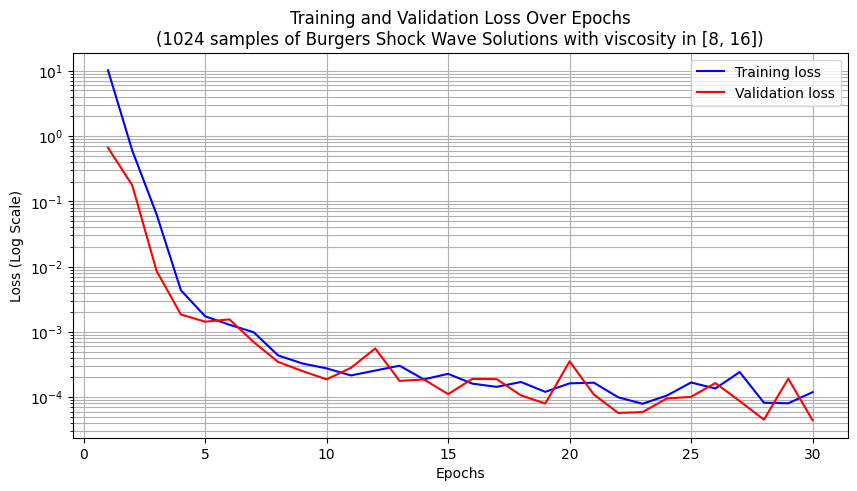

Training and validation loss curves plotted successfully.


In [ ]:
# Create a range for the x-axis (epochs)
epochs = range(1, len(train_losses) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title(f'Training and Validation Loss Over Epochs\n({num_viscosity_values} samples of Burgers Shock Wave Solutions with viscosity in [{min_nu}, {max_nu}])')
plt.xlabel('Epochs')
plt.ylabel('Loss (Log Scale)')
plt.yscale('log') # Set y-axis to log scale
plt.legend()
plt.grid(True, which="both", ls="-") # Ensure grid lines are visible with log scale
plt.show()

print("Training and validation loss curves plotted successfully.")

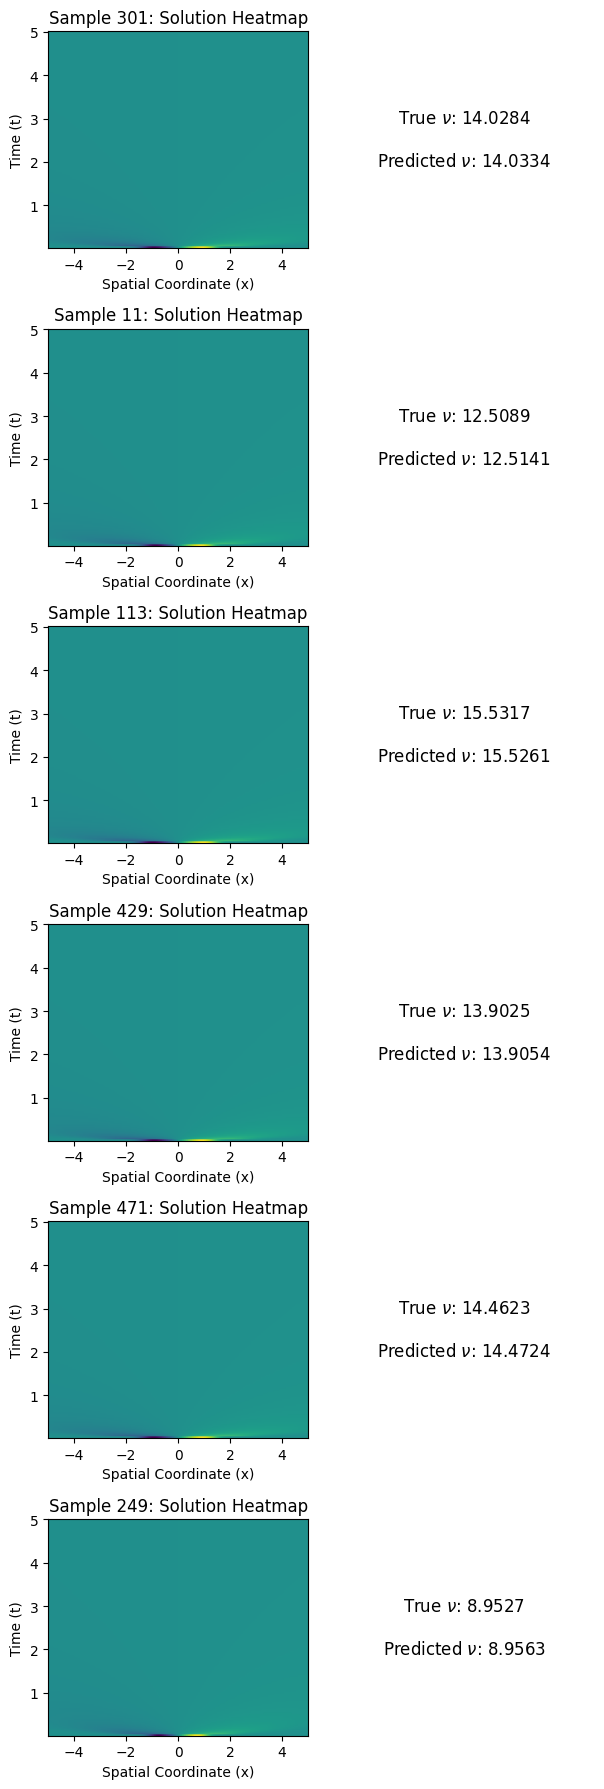

In [ ]:
# Set the model to evaluation mode
model.eval()

# Choose random indices from the training data
num_train_samples = X_train.shape[0]
random_indices = random.sample(range(num_train_samples), 6) # Changed to 6 random samples

plt.figure(figsize=(9, 3 * len(random_indices))) # Adjust figure height for 6 plots

for i, idx in enumerate(random_indices):
    # Get the sample solution and reshape for plotting (remove channel dimension)
    sample_solution = X_train[idx].squeeze().cpu().numpy()

    # Get the true viscosity (label)
    true_nu = y_train[idx].item()

    # Predict the viscosity using the model
    with torch.no_grad():
        predicted_nu = model(X_train[idx].unsqueeze(0)).item()

    # Subplot for heatmap
    plt.subplot(len(random_indices), 3, i * 3 + 1)
    img = plt.imshow(sample_solution, extent=[x_min, x_max, t_min, t_max],
                     origin='lower', aspect='auto', cmap='viridis')
    plt.title(f'Sample {idx+1}: Solution Heatmap')
    plt.xlabel('Spatial Coordinate (x)')
    plt.ylabel('Time (t)')

    # Subplot for Predicted and True Viscosity
    plt.subplot(len(random_indices), 3, i * 3 + 2)
    plt.text(0.5, 0.6, f'True $ν$: {true_nu:.4f}', fontsize=12, ha='center', va='center')
    plt.text(0.5, 0.4, f'Predicted $ν$: {predicted_nu:.4f}', fontsize=12, ha='center', va='center')
    #plt.title(f'Sample {idx+1}')
    plt.axis('off') # Hide axes for text display

plt.tight_layout()
plt.show()

#Test Inversion

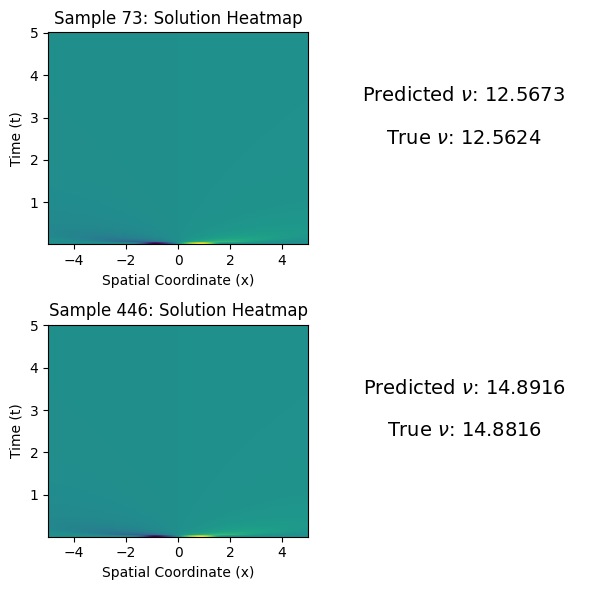

In [ ]:
# Set the model to evaluation mode
model.eval()

# Choose random indices from the training data
num_test_samples = X_test.shape[0]
random_indices = random.sample(range(num_test_samples), 2)

plt.figure(figsize=(9, 3 * len(random_indices)))

for i, idx in enumerate(random_indices):
    # Get the sample solution and reshape for plotting (remove channel dimension)
    sample_solution = X_test[idx].squeeze().cpu().numpy()

    # Get the true viscosity (label)
    true_nu = y_test[idx].item()

    # Predict the viscosity using the model
    with torch.no_grad():
        predicted_nu = model(X_test[idx].unsqueeze(0)).item()

    # Subplot for heatmap
    plt.subplot(len(random_indices), 3, i * 3 + 1)
    img = plt.imshow(u_solution, extent=[x_min, x_max, t_min, t_max],
                     origin='lower', aspect='auto', cmap='viridis')
    plt.title(f'Sample {idx+1}: Solution Heatmap')
    plt.xlabel('Spatial Coordinate (x)')
    plt.ylabel('Time (t)')

    # Subplot for Predicted and True Viscosity
    plt.subplot(len(random_indices), 3, i * 3 + 2)
    plt.text(0.5, 0.5, f'True $ν$: {true_nu:.4f}', fontsize=14, ha='center', va='center')
    plt.text(0.5, 0.7, f'Predicted $ν$: {predicted_nu:.4f}', fontsize=14, ha='center', va='center')
    #plt.title(f'Sample {idx+1}: True Viscosity')
    plt.axis('off') # Hide axes for text display

    # # Subplot for Predicted Viscosity
    # plt.subplot(len(random_indices), 3, i * 3 + 3)
    # plt.text(0.5, 0.5, f'Predicted $ν$: {predicted_nu:.4f}', fontsize=14, ha='center', va='center')
    # #plt.title(f'Sample {idx+1}: Predicted Viscosity')
    # plt.axis('off') # Hide axes for text display

plt.tight_layout()
plt.show()